In [1]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
from corner import corner

import jax
# jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
import numpyro
import tinygp

In [2]:
true = numpyro.distributions.Normal()
N = 100

In [3]:
x = true.sample(jax.random.PRNGKey(0), (N,))

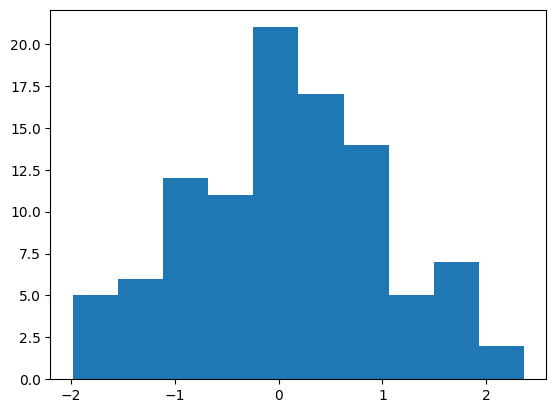

In [4]:
plt.hist(x);

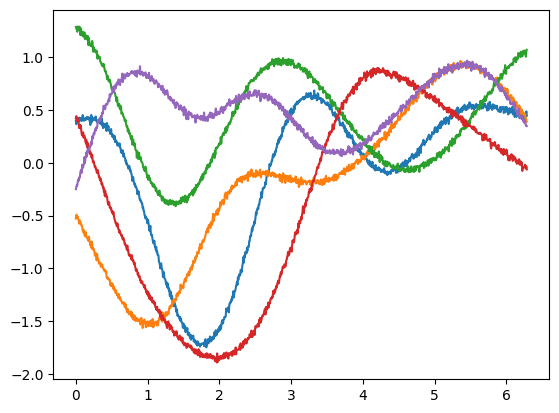

In [5]:
xx = jnp.linspace(0, 2 * np.pi, 1_000)
kernel = tinygp.kernels.ExpSquared(scale = 1)
gp = tinygp.GaussianProcess(kernel, xx)
yy = gp.sample(jax.random.PRNGKey(0), shape = (5,))
plt.plot(xx, yy.T);

In [6]:
xx = jnp.linspace(-3, 3, 100)

In [38]:
def model():
    mean = numpyro.sample(
        'loc',
        # numpyro.distributions.Uniform(-3, 3),
        numpyro.distributions.Normal(N, 1),
    )
    scale = numpyro.sample(
        'scale',
        # numpyro.distributions.Uniform(0, 2),
        numpyro.distributions.HalfNormal(),
    )
    sigma = numpyro.sample(
        'length',
        # numpyro.distributions.Uniform(0, 2),
        numpyro.distributions.HalfNormal(),
    )
    # kernel = sigma * tinygp.kernels.Matern52(scale)
    kernel = tinygp.kernels.quasisep.Matern52(scale, sigma)
    gp = tinygp.GaussianProcess(kernel, xx, mean = mean)
    _log_rates = numpyro.sample('log_rates', gp.numpyro_dist())
    log_rates = jnp.interp(x, xx, _log_rates)
    Nexp = numpyro.deterministic('Nexp', jnp.trapezoid(jnp.exp(_log_rates), xx))
    numpyro.factor('log_lkl', log_rates.sum())
    numpyro.factor('log_poiss', -Nexp)
    # numpyro.sample('_Nexp', numpyro.distributions.Poisson(Nexp), obs = N)

In [39]:
nuts = numpyro.infer.NUTS(model, max_tree_depth = 5)
mcmc = numpyro.infer.MCMC(nuts, num_warmup = 1_000, num_samples = 1_000)
mcmc.run(jax.random.PRNGKey(1))
mcmc.print_summary()

sample: 100%|████████| 2000/2000 [00:21<00:00, 95.13it/s, 31 steps of size 1.56e-06. acc. prob=0.88]



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
       length      2.12      0.00      2.12      2.12      2.12       nan      1.00
          loc     -0.75      0.00     -0.75     -0.75     -0.75      0.50      1.00
 log_rates[0]     -0.25      0.00     -0.25     -0.25     -0.25      0.55      1.02
 log_rates[1]     -1.76      0.00     -1.76     -1.76     -1.76      0.50      1.00
 log_rates[2]     -1.83      0.00     -1.83     -1.83     -1.83      0.50      1.00
 log_rates[3]      0.09      0.00      0.09      0.09      0.09      1.45      1.01
 log_rates[4]      0.68      0.00      0.68      0.68      0.68      0.50      1.00
 log_rates[5]      1.02      0.00      1.02      1.02      1.02      0.50      1.00
 log_rates[6]     -1.49      0.00     -1.49     -1.49     -1.49      0.50      1.00
 log_rates[7]     -0.99      0.00     -0.99     -0.99     -0.99      0.50      1.00
 log_rates[8]     -1.22      0.00     -1.22     -1.22     -1.22      0.50  

In [40]:
posterior = mcmc.get_samples()
log_rates = posterior.pop('log_rates')

ValueError: It looks like the parameter(s) in column(s) 1, 2, 3 have no dynamic range. Please provide a `range` argument.

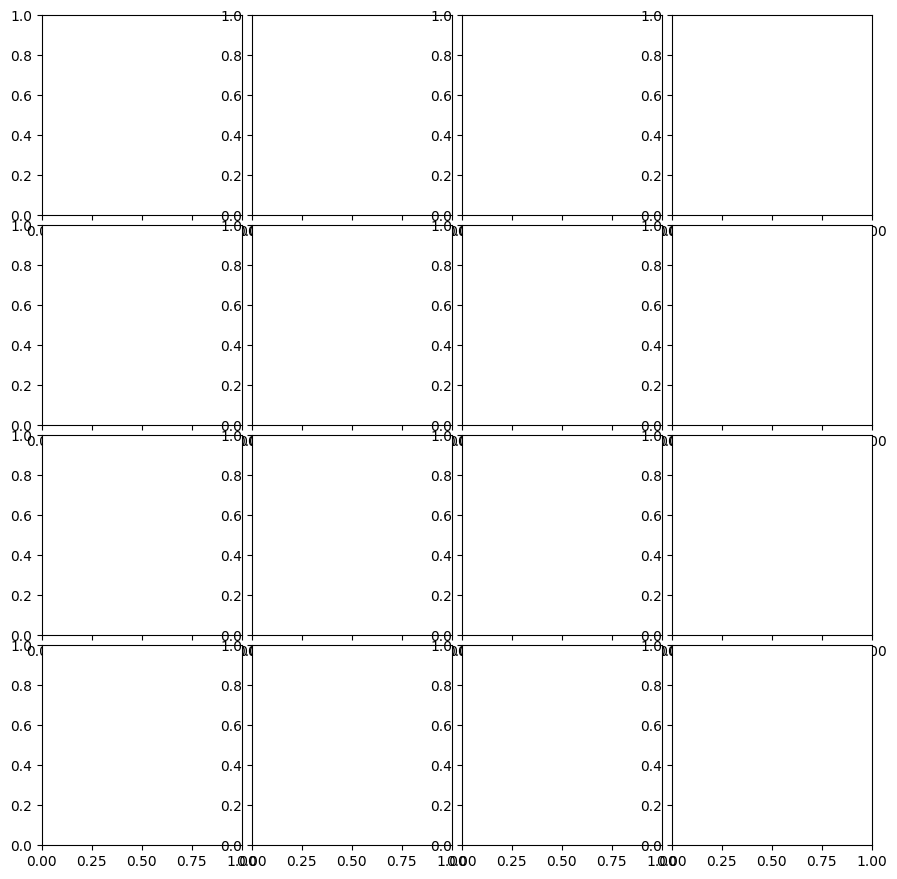

In [41]:
corner(
    np.transpose(list(posterior.values())),
    labels = list(posterior.keys()),
    truths = [N, None, None, None],
);

In [ ]:
h, b = np.histogram(x, density = True)
plt.stairs(h * N, b)
plt.scatter(x, jnp.ones_like(x), s = 1)
plt.plot(xx, np.quantile(jnp.exp(log_rates), (0.05, 0.5, 0.95), axis = 0).T)
plt.plot(xx, jnp.exp(true.log_prob(xx)) * N);